### ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png)

# Unit 6 Lab: Putting It All Together

## Overview

Welcome to the Unit 6 lab!

It's time to put together all of the pieces we've built. We're going to aggregate our data and create time series visualizations.

---

### Cleaning Our Data

The raw data is a mixture of varying forms of data points taken at different time intervals. The "FM-15" report type is the hourly data, so we can pull this out and discard the rest. To do so, we add `.query("REPORT_TYPE == 'FM-15'")` to the end of our `read_csv()` method.

Drop all columns of data, leaving only the `HourlyDryBulbTemperature` and `HourlyPrecipitation` columns.

Now, we need to clean the data in these two columns:
  - The data has added different letter characters at various places in the data. This has caused Pandas to read in all of the raw temperature and precipitation data as an object instead of a number. 
  - We need to change the type of all strings of data in each cell to `float64` and anything that's not a number to `0.0`. 
  - Use the following code to perform this transformation:
  
  ```hourly_weather_data = hourly_weather_data.apply(lambda x: pd.to_numeric(x, errors='coerce')).fillna(0.0).astype('float64')```

<details>
    <summary>Click here for details on how this apply method works.</summary>
What this code does is apply a lambda function to all of the data. A lambda function is a way of adding a more complex manipulation to data and can be as complex as any function you'd write in normal Python. What the function is doing here is, via `to_numeric()`, converting strings to numbers wherever it can (e.g., `"74"` to `74`). The `errors='coerce'` parameter tells the function that, every time it encounters a string that it doesn't know how to convert to a number (e.g., `"T"` to `?`), it should convert that string to a blank cell instead. Then, `fillna(0.0)` converts all of the blank cells to `0.0` and `astype('float64')` ensures that all cells in the column are of the `float64` type.
</details>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime


hourly_weather_data = pd.read_csv(
    './data/raw_weather_data.csv', 
    usecols=['DATE','REPORT_TYPE','HourlyDryBulbTemperature', 'HourlyPrecipitation'],
    parse_dates=["DATE"],
    low_memory=False,
    index_col="DATE").query("REPORT_TYPE == 'FM-15'")
hourly_weather_data = hourly_weather_data[['HourlyDryBulbTemperature','HourlyPrecipitation']]
hourly_weather_data = hourly_weather_data.apply(
    lambda x: pd.to_numeric(x, errors='coerce'))\
    .fillna(0.0).astype('float64')

### Resampling Our Data
Now, let's create some visualizations for our data.

First, we need to use a Pandas DataFrame method called `.resample()`. `.resample()` works very similarly to `.groupby()`. The difference is that `.resample()` is used for regrouping data around different time intervals. 

We can resample our data into 24-hour buckets. From there, we find the `max()`, `min()`, and `sum()` of each of those buckets. Note that we have a `DatetimeIndex` index in our DataFrame:
```
daily_highs = hourly_weather_data.resample('24H').max()
daily_lows = hourly_weather_data.resample('24H').min()
daily_rains = hourly_weather_data.resample('24H').sum()
```

This allows us to find the high temperature, low temperature, and total rainfall for each day over the last 10 years from our hourly data. Our original DataFrame had data points for each hour.

Run the cell below and notice how our `daily_highs` data now instead has one data point for each day. You can also see in the very last line of the cell that our number of rows is now 3,652 — the number of days in a 10-year period.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib.pyplot import figure

hourly_weather_data = pd.read_csv(
    './data/raw_weather_data.csv', 
    usecols=['DATE','REPORT_TYPE','HourlyDryBulbTemperature', 'HourlyPrecipitation'],
    parse_dates=["DATE"],
    low_memory=False,
    index_col="DATE").query("REPORT_TYPE == 'FM-15'")
hourly_weather_data = hourly_weather_data[['HourlyDryBulbTemperature','HourlyPrecipitation']]
hourly_weather_data = hourly_weather_data.apply(
    lambda x: pd.to_numeric(x, errors='coerce'))\
    .fillna(0.0).astype('float64')

daily_highs = hourly_weather_data.resample('24H').max()
daily_lows = hourly_weather_data.resample('24H').min()
daily_rains = hourly_weather_data.resample('24H').sum() 

print("Daily Highs: ",daily_highs.head(10))
print("Shape: ",daily_highs.shape)

Daily Highs:              HourlyDryBulbTemperature  HourlyPrecipitation
DATE                                                     
2009-01-01                      67.0                 0.00
2009-01-02                      70.0                 0.00
2009-01-03                      82.0                 0.00
2009-01-04                      63.0                 0.00
2009-01-05                      43.0                 0.00
2009-01-06                      67.0                 0.13
2009-01-07                      74.0                 0.00
2009-01-08                      80.0                 0.00
2009-01-09                      81.0                 0.00
2009-01-10                      68.0                 0.00
Shape:  (3652, 2)


   ### Shifting Our `__get_daily_chance_of_rain()` Calculations to the DataFrame
In Lab 3, we wrote the `__get_daily_chance_of_rain()` method to calculate the number of times it rained using a `for` loop. This is much more efficient to do in Pandas, so we're going to mutate our DataFrame using `.loc`.
   
Add the following lines of code and run the cell to update the data:
```
daily_rains.loc[daily_rains.HourlyPrecipitation < 0.25, 'HourlyPrecipitation'] = 0  
daily_rains.loc[daily_rains.HourlyPrecipitation > 0, 'HourlyPrecipitation'] = 1
```
<details>
    <summary>Click here for more information.</summary>
The first line counts days in which there was less than 1/4" of rain as `0` (no rain).
The second line then converts the remaining data to `1` (yes, there was rain).
We now have a binary data point for each calendar day over the 10-year period, which tells us whether or not it rained on a particular day.
</details>

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

hourly_weather_data = pd.read_csv(
    './data/raw_weather_data.csv', 
    usecols=['DATE','REPORT_TYPE','HourlyDryBulbTemperature', 'HourlyPrecipitation'],
    parse_dates=["DATE"],
    low_memory=False,
    index_col="DATE").query("REPORT_TYPE == 'FM-15'")
hourly_weather_data = hourly_weather_data[['HourlyDryBulbTemperature','HourlyPrecipitation']]
hourly_weather_data = hourly_weather_data.apply(
    lambda x: pd.to_numeric(x, errors='coerce'))\
    .fillna(0.0).astype('float64')

daily_highs = hourly_weather_data.resample('24H').max()
daily_lows = hourly_weather_data.resample('24H').min()
daily_rains = hourly_weather_data.resample('24H').sum() 

daily_rains.loc[daily_rains.HourlyPrecipitation < 0.25, 'HourlyPrecipitation'] = 0  
daily_rains.loc[daily_rains.HourlyPrecipitation > 0, 'HourlyPrecipitation'] = 1

### Grouping Our Data

Create three new DataFrames:

- `ten_year_avg_daily_highs`
- `ten_year_avg_daily_lows`
- `ten_year_avg_daily_rains`

These DataFrames take the data from `daily_highs`, `daily_lows`, and `daily_rains` and regroup them to find the:

- Mean of the highs, by day of the year.
- Mean of the lows, by day of the year.
- _Sum_ of rains for each day of the year over the last 10 years, by day of the year.

For example, let's say we have a daily high for 2/15 in 2009, 2010, 2011, etc. We want to group all 10 of those daily highs for the same calendar day together and find the average daily high for that specific day of the year (2/15).

_Hint: You'll need to use the `.index.dayofyear` ordinal in your `groupby()` function for this._

When you're done:

- Print out the first 10 rows of the `ten_year_avg_daily_highs` DataFrame.
- Print out the shape of this DataFrame — you should see that our data has now been reduced from 3,652 rows to 366 — one for each day of the year (including 2/29, as there were leap years that occurred over this 10-year timeframe).

In [4]:
ten_year_avg_daily_highs = daily_highs.groupby(daily_highs.index.dayofyear).mean()
ten_year_avg_daily_lows = daily_lows.groupby(daily_lows.index.dayofyear).mean()
ten_year_avg_daily_rains = daily_rains.groupby(daily_rains.index.dayofyear).sum()

print("10 Year", ten_year_avg_daily_highs.head(10))
print("Shape:", ten_year_avg_daily_highs.shape)

10 Year       HourlyDryBulbTemperature  HourlyPrecipitation
DATE                                               
1                         55.5                0.021
2                         53.3                0.040
3                         60.5                0.025
4                         56.3                0.006
5                         57.5                0.001
6                         57.3                0.045
7                         60.4                0.000
8                         56.8                0.024
9                         59.3                0.128
10                        58.9                0.019
Shape: (366, 2)


### Plotting Our Temperature Data
Add the necessary code below to plot the `ten_year_avg_daily_highs` and `ten_year_avg_daily_lows` DataFrames.


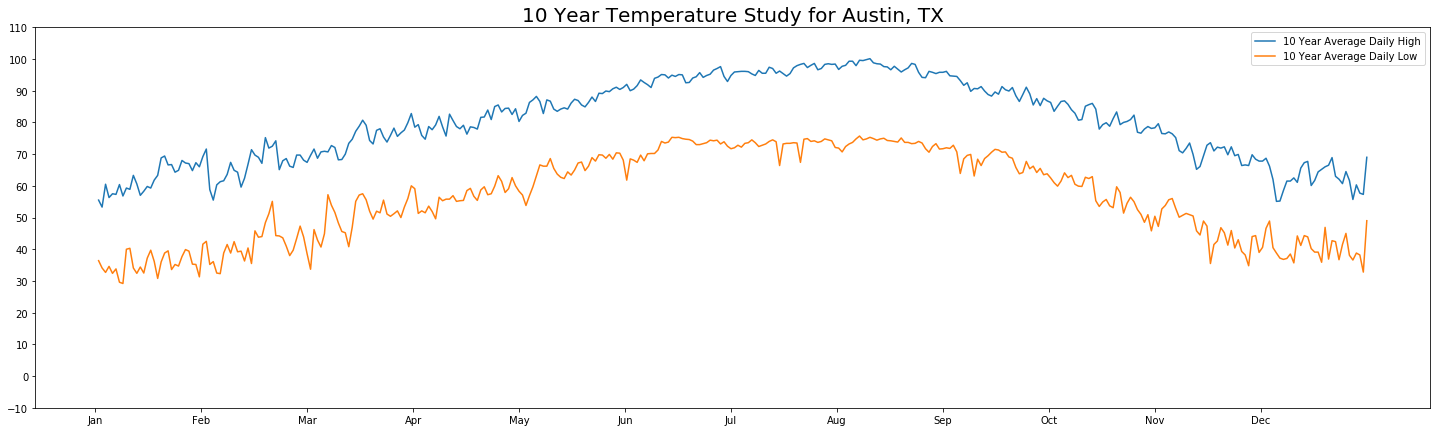

In [5]:
plt.figure(figsize=(25,7))

# Enter your code below:
plt.plot(ten_year_avg_daily_highs.index, ten_year_avg_daily_highs['HourlyDryBulbTemperature'], label='10 Year Average Daily High')
plt.plot(ten_year_avg_daily_highs.index, ten_year_avg_daily_lows['HourlyDryBulbTemperature'], label='10 Year Average Daily Low')

plt.title('10 Year Temperature Study for Austin, TX', fontsize=20)
plt.xticks(np.linspace(0,366,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
plt.yticks(range(-10, 120, 10))
plt.legend()

plt.show();

### Plotting Our Rain Data
Now, add the necessary code to create a line graph from the `ten_year_avg_daily_rains` DataFrame.

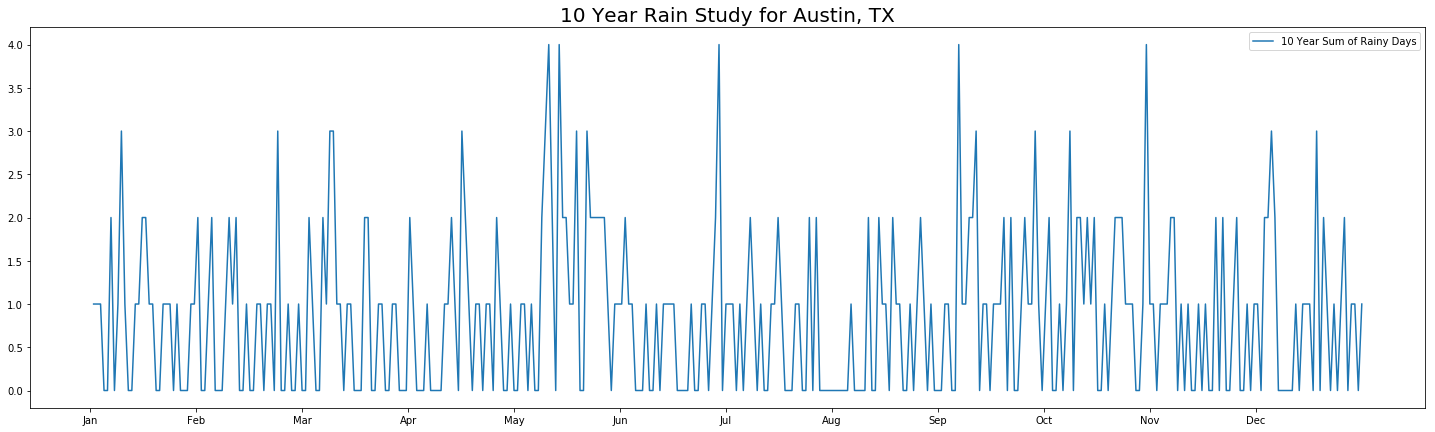

In [6]:
plt.figure(figsize=(25,7))

# Enter your code below:
plt.plot(ten_year_avg_daily_rains.index, ten_year_avg_daily_rains['HourlyPrecipitation'], label='10 Year Sum of Rainy Days')

plt.title('10 Year Rain Study for Austin, TX', fontsize=20)
plt.legend()
plt.xticks(np.linspace(0,366,13)[:-1], ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun','Jul','Aug','Sep','Oct', 'Nov', 'Dec'))
plt.show()

### Add User Input and Validation

We've added the `user_input_validation()` function we created back in Lab 2 into our `Forecast` class in the code below. Because it's now a method, we'll need to add `self` to its parameters. 

We'll be receiving `user_input_month` and `user_input_day` from a call for user input made inside of the method rather than outside of it. This means we can remove `user_input_month` and `user_input_day` from the method's parameters and  instead declare them as empty string variables inside of our method.

Next, we're going to take all four of our `if` statements and move them inside of an infinite `while` loop. We create an infinite `while` loop by setting the condition for the `while` loop to `True`.

Now, add the following three lines of code inside our `while` loop ahead of all of the `if` statements:

```python
date = input("Please enter the date you would like a forecast for (MM/DD): ").split("/")
month = int(date[0])
day = int(date[1])
```

<details>
    <summary>Click here for details on how this works.</summary>
The first line of this code causes Python to create a prompt for the user and wait on them for input. It then takes the string entered by the user and cuts it into pieces anywhere it finds a <code>/</code>. Then, it stores the pieces in a list called <code>date</code>. The second and third lines read out the first and second items in that list and convert the contents from strings to integers.
</details>

In the fourth `if` statement inside the `while` loop, change the line from `return True` to `break`. This will cause our method to exit the `while` loop once the user enters a date that meets our criteria.

Remove the `self.forecast_date = datetime.datetime(self.forecast_year,user_input_month,user_input_day)` line from our `Forecast` initialization function and use it to replace the `return False` statement at the very end of our `user_input_validation()` method, outside of the `while` loop.

Finally, remove `user_input_month` and `user_input_day` from the initialization method and add a call to our `user_input_validation()` method. 

Test everything out by running the cell. Try adding a few invalid dates and watch what happens. Our loop will kick in and prompt you for a new input.

In [7]:
import datetime
import calendar

one_day_of_hourly_temperatures = [67,67,68,69,71,73,75,76,79,81,81,80,82,81,81,80,78,75,72,70,67,65,66,66]
one_day_of_hourly_humidity = [60,65,65,70,70,70,70,75,75,75,75,80,80,85,85,85,85,80,80,80,80,80,80,80]
one_day_of_hourly_rainfall = [0,0,0,0.1,0.1,0.05,0.1,0.15,0.2,0.3,0.3,0.5,0,0,0,0,0,0,0,0,0,0,0,0]

class Forecast():
    
    def __init__(self, location):
        self.location = location
        self.forecast_year = datetime.datetime.now().year
        self.__user_input_validation()
    
    def __get_day_of_week(self, date):
        return calendar.day_name[date.weekday()]
    
    def __get_daily_high(self):
        return max(one_day_of_hourly_temperatures)
    
    def __get_daily_low(self):
        return min(one_day_of_hourly_temperatures)
    
    def __get_daily_chance_of_rain(self):
        number_of_years_of_data = 10
        times_it_has_rained = 0
        
        if sum(one_day_of_hourly_rainfall):
            times_it_has_rained += 1
            
        return times_it_has_rained / number_of_years_of_data * 100
    
    def display_daily_forecast(self):
        day_of_week = self.__get_day_of_week(self.forecast_date)
        print(f"The weather forecast for {day_of_week} "
              f"{self.forecast_date.month}/{self.forecast_date.day}"
              f" in {self.location} is: High of "
              f"{self.__get_daily_high()}, Low of {self.__get_daily_low()}"
              f", with a {self.__get_daily_chance_of_rain()}% chance of rain.")
    
    def display_weekly_forecast(self):
        print("The week\'s weather forecast for:")
              
        for i in range(7):
            current_date = self.forecast_date + datetime.timedelta(days=i)
            print(f"   {self.__get_day_of_week(current_date)},"
                  f"{current_date.month}/{current_date.day}: "
                  f"High {self.__get_daily_high()}, Low {self.__get_daily_low()},"
                  f" Rain {self.__get_daily_chance_of_rain()}%")
            
    def __user_input_validation(self):
        valid_month = False
        valid_day = False
        valid_date = False
        user_input_month = ""
        user_input_day = ""

        while True:
            date = input("Please enter the date you would like a forecast for (MM/DD): ").split("/")
            user_input_month = int(date[0])
            user_input_day = int(date[1])

            if user_input_month < 1 or user_input_month > 12:
                valid_month = False
                print("Invalid month. Please enter a number between 1-12.")
            else:
                valid_month = True

            if  user_input_day < 1 or user_input_day > 31:
                valid_day = False
                print("Invalid day. Please enter a number between 1-12.")
            else:
                valid_day = True

            if (user_input_month in [2,4,6,9,11] and user_input_day > 30) or (user_input_month == 2 and user_input_day > 28):
                valid_date = False
                print("Invalid date. Please enter a valid date.")
            else:
                valid_date = True

            if valid_month and valid_day and valid_date:
                break

        self.forecast_date = datetime.datetime(self.forecast_year,user_input_month,user_input_day)
            
test = Forecast("Austin, TX")
test.display_weekly_forecast()

Please enter the date you would like a forecast for (MM/DD): 1/22
The week's weather forecast for:
   Tuesday,1/22: High 82, Low 65, Rain 10.0%
   Wednesday,1/23: High 82, Low 65, Rain 10.0%
   Thursday,1/24: High 82, Low 65, Rain 10.0%
   Friday,1/25: High 82, Low 65, Rain 10.0%
   Saturday,1/26: High 82, Low 65, Rain 10.0%
   Sunday,1/27: High 82, Low 65, Rain 10.0%
   Monday,1/28: High 82, Low 65, Rain 10.0%


### Updating Our `Forecast` Class to Work With Real Data

First, we'll modify our getter methods to use the date input from our `__user_input_validation()` method:

- Add the `date` argument (of type `datetime.datetime`) to the `__get_daily_high()`, `__get_daily_low()`, and `__get_daily_chance_of_rain()` methods.
- Inside the `display_daily_forecast()` and `display_weekly_forecast()` methods, pass the `self.forecast_date` parameter into the three getter methods we just altered.

<i>Hint: You'll need to use <code>date.timetuple().tm_yday</code> in order to convert the date the function receives into the respective day of year you need.<i>

Next, we'll change our getter methods to pull from our Pandas DataFrame instead of our `one_day_of_hourly_xxx` lists:

- Change the return statements in the three getter functions mentioned above to pull their data from the respective DataFrames instead of from the "one_day_of" static lists.

Finally, inside the `__get_daily_chance_of_rain()` method, remove the lines...
```python
times_it_has_rained = 0
if sum(one_day_of_hourly_rainfall):
    times_it_has_rained += 1
```
...as we shifted that calculation to be done by the DataFrame itself.


#### That's it! You should now have a fully functioning weather forecasting application that can give you a daily or weekly forecast for any day of the year. Run the cell and test it out.

In [8]:
import datetime
import calendar


class Forecast():
    
    def __init__(self, location):
        self.location = location
        self.forecast_year = datetime.datetime.now().year
        self.__user_input_validation()
    
    def __get_day_of_week(self, date):
        return calendar.day_name[date.weekday()]
    
    def __get_daily_high(self, date):
        return ten_year_avg_daily_highs['HourlyDryBulbTemperature'][date.timetuple().tm_yday]
    
    def __get_daily_low(self, date):
        return ten_year_avg_daily_lows['HourlyDryBulbTemperature'][date.timetuple().tm_yday]
       
    def __get_daily_chance_of_rain(self, date):
        number_of_years_of_data = 10
        times_it_has_rained = 0
        
        if sum(one_day_of_hourly_rainfall):
            times_it_has_rained += 1
            
        return ten_year_avg_daily_rains['HourlyPrecipitation'][date.timetuple().tm_yday] / number_of_years_of_data * 100
    
    def display_daily_forecast(self):
        day_of_week = self.__get_day_of_week(self.forecast_date)
        print(f"The weather forecast for {day_of_week} "
              f"{self.forecast_date.month}/{self.forecast_date.day}"
              f" in {self.location} is: High of "
              f"{self.__get_daily_high(self.forecast_date)}, "
              f"Low of {self.__get_daily_low(self.forecast_date)}, "
              f"with a {self.__get_daily_chance_of_rain(self.forecast_date)}%"
              f" chance of rain.")
    
    def display_weekly_forecast(self):
        print("The week\'s weather forecast for:")
              
        for i in range(7):
            current_date = self.forecast_date + datetime.timedelta(days=i)
            print(f"   {self.__get_day_of_week(current_date)}, "
                  f"{current_date.month}/{current_date.day}: "
                  f"High {self.__get_daily_high(current_date)}, :"
                  f"Low {self.__get_daily_low(current_date)}, Rain"
                  f"{self.__get_daily_chance_of_rain(current_date)}%")
    
    def __user_input_validation(self):
        valid_month = False
        valid_day = False
        valid_date = False
        user_input_month = ""
        user_input_day = ""

        while True:
            date = input("Please enter the date you would like a forecast for (MM/DD): ").split("/")
            user_input_month = int(date[0])
            user_input_day = int(date[1])

            if user_input_month < 1 or user_input_month > 12:
                valid_month = False
                print("Invalid month. Please enter a number between 1-12.")
            else:
                valid_month = True

            if  user_input_day < 1 or user_input_day > 31:
                valid_day = False
                print("Invalid day. Please enter a number between 1-12.")
            else:
                valid_day = True

            if (user_input_month in [2,4,6,9,11] and user_input_day > 30) or \
                (user_input_month == 2 and user_input_day > 28):
                valid_date = False
                print("Invalid date. Please enter a valid date.")
            else:
                valid_date = True

            if valid_month and valid_day and valid_date:
                break

        self.forecast_date = datetime.datetime(self.forecast_year,user_input_month,user_input_day)
        
    
test = Forecast("Austin,TX")
test.display_daily_forecast()
test.display_weekly_forecast()

Please enter the date you would like a forecast for (MM/DD): 1/22
The weather forecast for Tuesday 1/22 in Austin,TX is: High of 66.7, Low of 33.6, with a 10.0% chance of rain.
The week's weather forecast for:
   Tuesday, 1/22: High 66.7, :Low 33.6, Rain10.0%
   Wednesday, 1/23: High 64.3, :Low 35.2, Rain10.0%
   Thursday, 1/24: High 64.9, :Low 34.7, Rain0.0%
   Friday, 1/25: High 68.0, :Low 37.7, Rain10.0%
   Saturday, 1/26: High 67.2, :Low 39.9, Rain0.0%
   Sunday, 1/27: High 67.0, :Low 39.4, Rain0.0%
   Monday, 1/28: High 64.8, :Low 35.3, Rain0.0%
